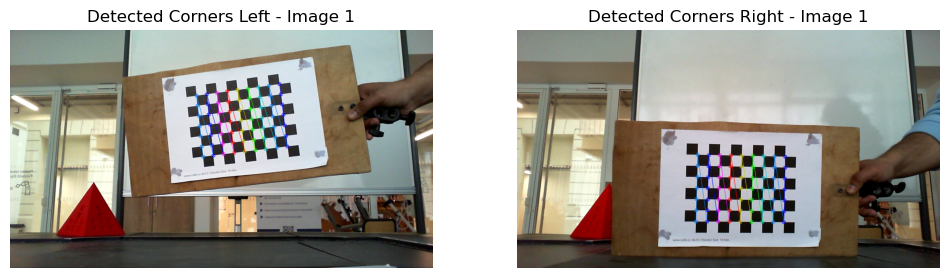

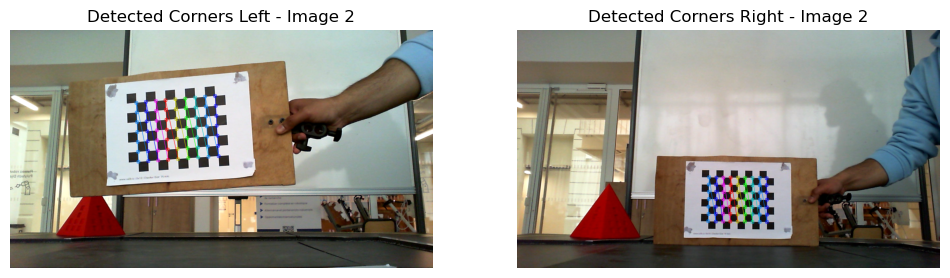

Mean Reprojection Error for Left Camera: 0.01 pixels
Mean Reprojection Error for Right Camera: 0.01 pixels
==== Stereo Camera Calibration Results ====
Camera Matrix Left:
 [[1.16366046e+03 0.00000000e+00 6.62600532e+02]
 [0.00000000e+00 1.15421879e+03 3.74137704e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients Left:
 [ 0.1262585  -1.17468558  0.0066203   0.00375547  2.00425912]

Camera Matrix Right:
 [[1.20349968e+03 0.00000000e+00 6.34581160e+02]
 [0.00000000e+00 1.19304912e+03 3.41062016e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients Right:
 [ 1.45935705e-01 -1.67058653e+00  6.53536044e-03 -4.41006893e-04
  3.46663244e+00]


In [20]:
# 1) Camera Calibration (Stereo)
# Import necessary libraries
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

# Configuration: (user-defined to easily modify)
pattern_size = (7, 9)  # internal corners (height, width)
square_length = 15.0  # size of a square (cm)
image_path_left = "Sameed/Set_1/Set_1/left/*.png"
image_path_right = "Sameed/Set_1/Set_1/right/*.png"


# Generate 3D world coordinates
world_points = np.zeros((pattern_size[0] * pattern_size[1], 3), dtype=np.float32)
world_points[:, :2] = np.indices((pattern_size[0], pattern_size[1])).T.reshape(-1, 2) * square_length

# Store points and image locations
object_points = []  # 3D points in world space
image_points_left = []  # 2D points for left image
image_points_right = []  # 2D points for right image

# Load images dynamically
left_images = glob.glob(image_path_left)
right_images = glob.glob(image_path_right)

# Process each image
for idx, (left_file, right_file) in enumerate(zip(left_images, right_images)):
    left_image = cv2.imread(left_file)
    right_image = cv2.imread(right_file)
    grayscale_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    grayscale_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
    
    found_left, corners_left = cv2.findChessboardCorners(grayscale_left, pattern_size, None)
    found_right, corners_right = cv2.findChessboardCorners(grayscale_right, pattern_size, None)
    
    if found_left and found_right:
        object_points.append(world_points)
        image_points_left.append(corners_left)
        image_points_right.append(corners_right)
        
        # Refine corner locations
        corners_left_subpix = cv2.cornerSubPix(grayscale_left, corners_left, (11, 11), (-1, -1), 
                                               criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        corners_right_subpix = cv2.cornerSubPix(grayscale_right, corners_right, (11, 11), (-1, -1), 
                                                criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        
        # Optional: Display detected corners (only first 2 images)
        if idx < 2:
            left_image_rgb = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
            right_image_rgb = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
            cv2.drawChessboardCorners(left_image_rgb, pattern_size, corners_left_subpix, found_left)
            cv2.drawChessboardCorners(right_image_rgb, pattern_size, corners_right_subpix, found_right)
            
            plt.figure(figsize=(12, 6))
            plt.subplot(121), plt.imshow(left_image_rgb)
            plt.title(f"Detected Corners Left - Image {idx+1}")
            plt.axis("off")
            plt.subplot(122), plt.imshow(right_image_rgb)
            plt.title(f"Detected Corners Right - Image {idx+1}")
            plt.axis("off")
            plt.show()

# Perform stereo camera calibration (using the accumulated object and image points)
# Use one image to get the shape (just after the loop)
grayscale_left = cv2.cvtColor(cv2.imread(left_images[0]), cv2.COLOR_BGR2GRAY)
grayscale_right = cv2.cvtColor(cv2.imread(right_images[0]), cv2.COLOR_BGR2GRAY)

ret, camera_matrix_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(
    object_points, image_points_left, grayscale_left.shape[::-1], None, None)
ret, camera_matrix_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(
    object_points, image_points_right, grayscale_right.shape[::-1], None, None)

# Store calibration data for future use
calibration_data = {
    "camera_matrix_left": camera_matrix_left,
    "dist_left": dist_left,
    "camera_matrix_right": camera_matrix_right,
    "dist_right": dist_right
}

# Calculate the reprojection error
mean_error_left = 0
mean_error_right = 0

# Calculate reprojection error for left and right images
for i in range(len(object_points)):
    img_points_left_proj, _ = cv2.projectPoints(object_points[i], rvecs_left[i], tvecs_left[i], camera_matrix_left, dist_left)
    img_points_right_proj, _ = cv2.projectPoints(object_points[i], rvecs_right[i], tvecs_right[i], camera_matrix_right, dist_right)
    
    error_left = cv2.norm(image_points_left[i], img_points_left_proj, cv2.NORM_L2) / len(img_points_left_proj)
    error_right = cv2.norm(image_points_right[i], img_points_right_proj, cv2.NORM_L2) / len(img_points_right_proj)
    
    mean_error_left += error_left
    mean_error_right += error_right

mean_error_left /= len(object_points)
mean_error_right /= len(object_points)

# Print reprojection errors
print(f"Mean Reprojection Error for Left Camera: {mean_error_left:.2f} pixels")
print(f"Mean Reprojection Error for Right Camera: {mean_error_right:.2f} pixels")

# Print and store the calibration results
with open("calibration_results.txt", "w") as f:
    f.write("==== Stereo Camera Calibration Results ====\n")
    f.write(f"Camera Matrix Left:\n{camera_matrix_left}\n")
    f.write(f"Distortion Coefficients Left:\n{dist_left.ravel()}\n")
    f.write(f"Camera Matrix Right:\n{camera_matrix_right}\n")
    f.write(f"Distortion Coefficients Right:\n{dist_right.ravel()}\n")
    f.write(f"Mean Reprojection Error Left: {mean_error_left:.2f} pixels\n")
    f.write(f"Mean Reprojection Error Right: {mean_error_right:.2f} pixels\n")

# Show calibration results
print("==== Stereo Camera Calibration Results ====")
print("Camera Matrix Left:\n", camera_matrix_left)
print("\nDistortion Coefficients Left:\n", dist_left.ravel())
print("\nCamera Matrix Right:\n", camera_matrix_right)
print("\nDistortion Coefficients Right:\n", dist_right.ravel())




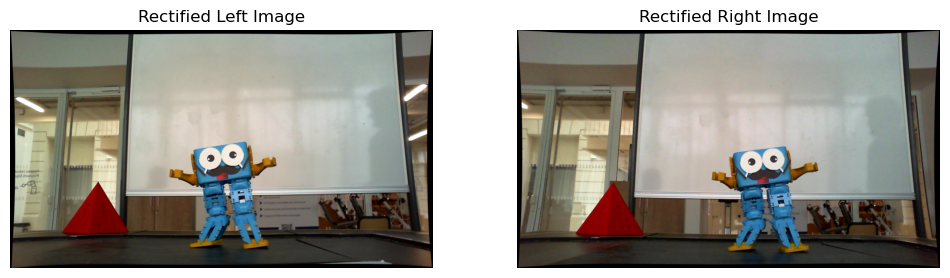

In [ ]:

import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

# Load calibration data from JSON file
with open('calibration_results.json') as f:
    calibration_data = json.load(f)

# Extract necessary parameters
camera_matrix_left = np.array(calibration_data['camera_matrix_left'])
dist_left = np.array(calibration_data['dist_left'])
camera_matrix_right = np.array(calibration_data['camera_matrix_right'])
dist_right = np.array(calibration_data['dist_right'])
R = np.array(calibration_data['R'])
T = np.array(calibration_data['T']).flatten()  # Flatten to 1D array

# Load images for stereo rectification
img_left = cv2.imread("Sameed/Set_1/Set_1/stereo/left/left_0.png")
img_right = cv2.imread("Sameed/Set_1/Set_1/stereo/right/right_0.png")

# Undistort images
img_left_undistorted = cv2.undistort(img_left, camera_matrix_left, dist_left)
img_right_undistorted = cv2.undistort(img_right, camera_matrix_right, dist_right)

# Stereo rectification
rectify_scale = 1.0  # Full image area
(R1, R2, P1, P2, Q, roi1, roi2) = cv2.stereoRectify(
    cameraMatrix1=camera_matrix_left, distCoeffs1=dist_left,
    cameraMatrix2=camera_matrix_right, distCoeffs2=dist_right,
    imageSize=img_left.shape[:2][::-1], R=R, T=T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=rectify_scale)

# Apply rectification
map_left_x, map_left_y = cv2.initUndistortRectifyMap(
    camera_matrix_left, dist_left, R1, P1, img_left.shape[:2][::-1], cv2.CV_32FC1)
map_right_x, map_right_y = cv2.initUndistortRectifyMap(
    camera_matrix_right, dist_right, R2, P2, img_right.shape[:2][::-1], cv2.CV_32FC1)

img_left_rectified = cv2.remap(img_left_undistorted, map_left_x, map_left_y, cv2.INTER_LINEAR)
img_right_rectified = cv2.remap(img_right_undistorted, map_right_x, map_right_y, cv2.INTER_LINEAR)

# Display rectified images
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2RGB))
plt.title("Rectified Left Image"), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2RGB))
plt.title("Rectified Right Image"), plt.axis('off')
plt.show()

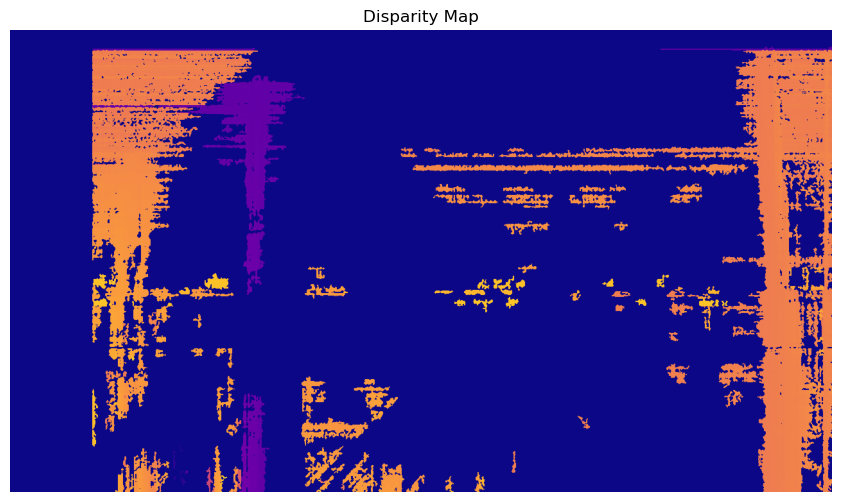

In [71]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

# Load calibration data from JSON file
with open('calibration_results.json') as f:
    calibration_data = json.load(f)

# Extract necessary parameters
camera_matrix_left = np.array(calibration_data['camera_matrix_left'])
dist_left = np.array(calibration_data['dist_left'])
camera_matrix_right = np.array(calibration_data['camera_matrix_right'])
dist_right = np.array(calibration_data['dist_right'])
R = np.array(calibration_data['R'])
T = np.array(calibration_data['T']).flatten()  # Flatten to 1D array
Q = np.array(calibration_data['Q'])  # Extract Q matrix from calibration data

# Load the rectified images (from the previous steps)
img_left_rectified = cv2.imread("Sameed/Set_1/Set_1/stereo/left/left_0_rectified.png")
img_right_rectified = cv2.imread("Sameed/Set_1/Set_1/stereo/right/right_0_rectified.png")

# Check if images are loaded properly
if img_left_rectified is None:
    print("Error loading left rectified image!")
if img_right_rectified is None:
    print("Error loading right rectified image!")

# Convert the images to grayscale (StereoSGBM works on single-channel images)
img_left_gray = cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2GRAY)
img_right_gray = cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2GRAY)

# Step 1: Compute the disparity map using StereoSGBM
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=128,  # Must be divisible by 16
    blockSize=1,
    P1=8 * 3 * 11 ** 2,
    P2=32 * 3 * 11 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=100,
    speckleRange=32
)

# Compute disparity map
disparity = stereo.compute(img_left_gray, img_right_gray).astype(np.float32) / 16.0

# Ensure disparity values are within a reasonable range
disparity = np.clip(disparity, 0, 255)

# Display Disparity Map
plt.figure(figsize=(12, 6))
plt.imshow(disparity, cmap='plasma')
plt.title("Disparity Map")
plt.axis('off')
plt.show()


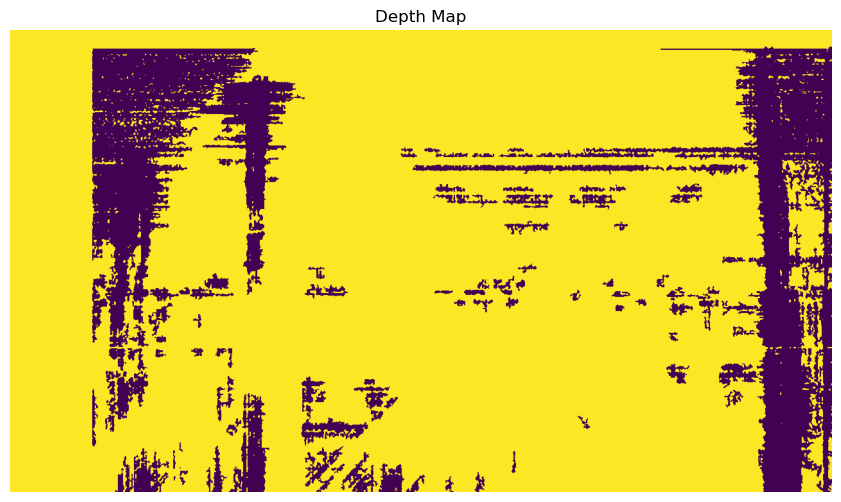

In [72]:

# Step 2: Convert disparity to depth map using the Q matrix
depth_map = cv2.reprojectImageTo3D(disparity, Q)

# Ensure depth values are valid and clip extreme values for better visualization
depth_map = np.clip(depth_map, 0, 255)

# Display Depth Map (Using Z-axis of 3D points)
plt.figure(figsize=(12, 6))
plt.imshow(depth_map[:, :, 2], cmap='viridis')  # Use Z-axis depth values
plt.title("Depth Map")
plt.axis('off')
plt.show()

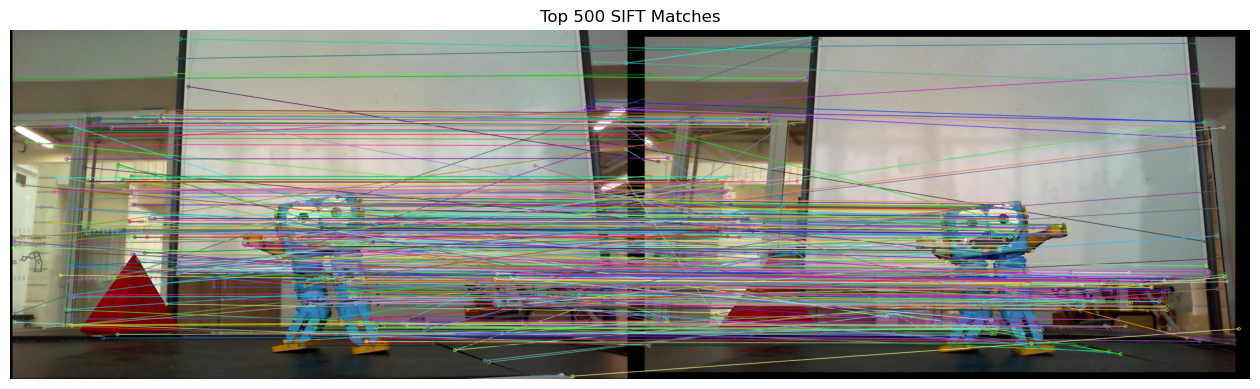

In [ ]:
# Feature Detection using SIFT
sift = cv2.SIFT_create()

# Convert to grayscale for feature detection
gray_left = cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2GRAY)

# Detect keypoints and compute descriptors
kp_left, desc_left = sift.detectAndCompute(gray_left, None)
kp_right, desc_right = sift.detectAndCompute(gray_right, None)

# Use BFMatcher for feature matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(desc_left, desc_right)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Display matches
N_MATCHES_TO_DISPLAY = 500
matched_image = cv2.drawMatches(
    img_left_rectified, kp_left,
    img_right_rectified, kp_right,
    matches[:N_MATCHES_TO_DISPLAY], None, 
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title(f"Top {N_MATCHES_TO_DISPLAY} SIFT Matches")
plt.axis("off")
plt.show()





In [ ]:
E, mask = cv2.findEssentialMat(
    pts_left, pts_right, camera_matrix_left, method=cv2.RANSAC, prob=0.999, threshold=50.0
)

# Print the Essential Matrix
print(f"Estimated Essential Matrix:\n{E}\n")

# Recover the relative pose (rotation and translation)
_, R_est, t_est, mask_pose = cv2.recoverPose(E, pts_left, pts_right, camera_matrix_left, mask=mask)

# Display the recovered pose (rotation matrix R and translation vector t)
print("Recovered Pose:")
print(f"Rotation matrix (R):\n{R_est}")
print(f"Translation vector (t):\n{t_est}")

# Count how many points were kept as inliers
inlier_count = np.count_nonzero(mask_pose)
print(f"recoverPose inliers: {inlier_count}/{len(mask_pose)} ({100*inlier_count/len(mask_pose):.2f}%)")


Estimated Essential Matrix:
[[ 0.00095866 -0.13668011  0.0554719 ]
 [ 0.026041   -0.00679587 -0.70444072]
 [-0.01533743  0.69356493  0.0034493 ]]

Recovered Pose:
Rotation matrix (R):
[[ 0.9859209  -0.0568986  -0.15723397]
 [ 0.05641412  0.99837894 -0.00754609]
 [ 0.15740845 -0.00143037  0.98753255]]
Translation vector (t):
[[0.97799846]
 [0.07796094]
 [0.19349703]]
recoverPose inliers: 321/354 (90.68%)


[Triangulation] Reconstructed 321 3D points.


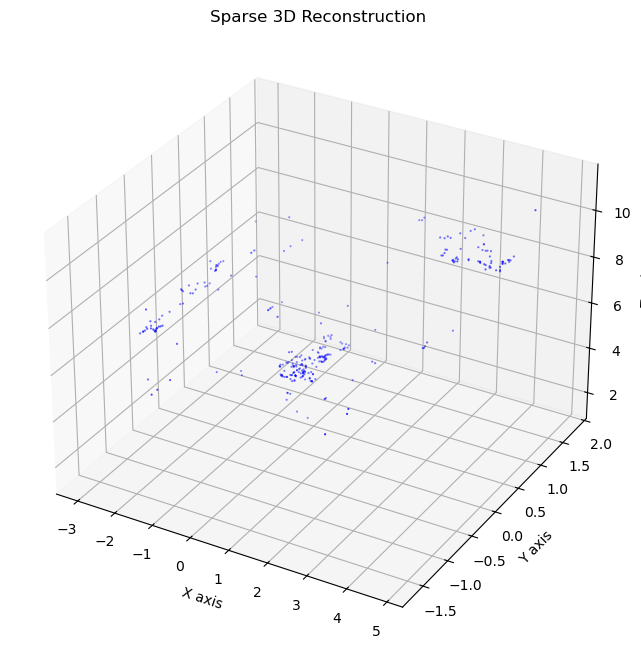

In [40]:
# Triangulation: Reconstruct 3D points from the stereo pair

# Construct the projection matrices for each camera
P1 = camera_matrix_left @ np.hstack((np.eye(3), np.zeros((3, 1))))  # First camera at the origin
P2 = camera_matrix_right @ np.hstack((R_est, t_est))  # Second camera using the recovered pose

# Points to be triangulated (from inliers only)
pts_left_in = pts_left[mask_pose.ravel() == 1]
pts_right_in = pts_right[mask_pose.ravel() == 1]

# Perform triangulation using OpenCV
pts_left_in_2d = pts_left_in.reshape(-1, 2).T.astype(np.float32)
pts_right_in_2d = pts_right_in.reshape(-1, 2).T.astype(np.float32)

points_4d_hom = cv2.triangulatePoints(P1, P2, pts_left_in_2d, pts_right_in_2d)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3, :] / points_4d_hom[3, :]  # Convert to non-homogeneous coordinates

print(f"[Triangulation] Reconstructed {points_3d.shape[1]} 3D points.")

# 3D visualization (optional, with matplotlib)
x_vals = points_3d[0, :]
y_vals = points_3d[1, :]
z_vals = points_3d[2, :]

# Plotting the sparse 3D reconstruction
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, z_vals, s=1, c='b', marker='.')
ax.set_title("Sparse 3D Reconstruction")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
plt.show()


In [41]:
import plotly.graph_objects as go

# 3D visualization using Plotly for better interactivity
x_vals = points_3d[0, :]
y_vals = points_3d[1, :]
z_vals = points_3d[2, :]

# Create a 3D scatter plot with Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(size=2, color='blue')
)])

# Set plot titles and labels
fig.update_layout(
    title="Sparse 3D Reconstruction",
    scene=dict(
        xaxis_title="X axis",
        yaxis_title="Y axis",
        zaxis_title="Z axis"
    ),
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins for better visualization
)

# Show the interactive 3D plot in a new window
fig.show()

# Optionally, save the plot as an HTML file
# fig.write_html("3d_reconstruction.html")


***Dense Reconstruction***